# Intro and overview

Methods from survival analysis are used to model time-to-event data when censoring is present. Such techniques are a natural choice when it comes to predicting or understanding churn in customer subscriptions. In this notebook, we explore how survival analysis helps to understand the reasons for why customers churn.

A quick and simple method is to use Cox Proportional Hazards models:

$h(t|x) = h_0(t) \exp(\beta x)$

where $h(t|x)$ and $h_0(t)$ are the conditional and baseline hazard functions. Estimates of vector $\beta$ will reveal factors that result in churn.

### Dataset
Data is taken from the following URL:
- https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code?datasetId=13996

### Columns
These are the columns included in this analysis:
- Gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
- Dependents: Whether the customer has dependents or not (Yes, No)
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- tenure: Number of months the customer has stayed with the company
- Churn: Whether the customer churned or not (Yes or No)

In [1]:
import pandas as pd

df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.columns)
#'gender', 'SeniorCitizen', 'Dependents', 
categorical_cols = ['Partner','PhoneService', 'InternetService', 'Contract','PaymentMethod',]
for col in categorical_cols:
    df[col] = df[col].astype('category')

numerical_cols = ['MonthlyCharges',]
df['churn'] = [1 if x == 'Yes' else 0 for x in df['Churn']]
df = df[['churn','tenure',*categorical_cols,*numerical_cols]]

feature_df = pd.concat([
    df[['churn','tenure']],
    df[numerical_cols],
    pd.get_dummies(df[categorical_cols],drop_first=True)
    ],
    axis=1)
feature_df.head(3)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,churn,tenure,MonthlyCharges,Partner_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,True,False,False,False,False,False,False,True,False
1,0,34,56.95,False,True,False,False,True,False,False,False,True
2,1,2,53.85,False,True,False,False,False,False,False,False,True


Before fitting a Cox model, we can plot survival graphs to get a sense of churn patterns

Text(0.5, 1.0, 'Kaplan-Meier Curve (churn proprotion across months)')

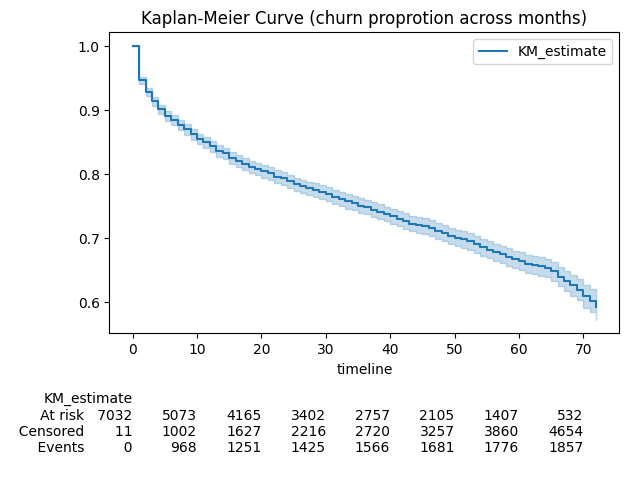

In [2]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

km = KaplanMeierFitter()
km.fit(feature_df['tenure'], event_observed=feature_df['churn'])
km.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve (churn proprotion across months)')

From this we already see that there is a lot of churn in the first few months but churn rate slows to a steady and somewhat constant rate as time passes. There is a surviving fraction of around 60% beyond 70 months. Some people are never observed to churn despite being the earliest subscribers.

Text(0.5, 1.0, 'Survival curves by payment method')

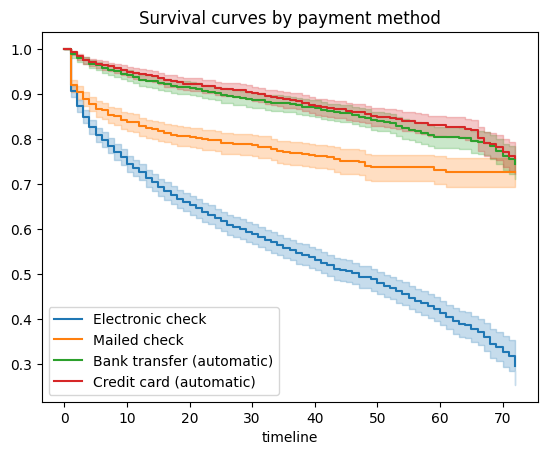

In [3]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for payment_method in df['PaymentMethod'].unique():
    selector = df['PaymentMethod'] == payment_method
    kmf.fit(df.tenure[selector], event_observed = df.churn[selector], label = payment_method)
    kmf.plot(ax=ax)
plt.title("Survival curves by payment method")

There are some visible differences in survival curves when we split customers by payment methods.

We can now proceed to fit a model to investigate reasons for churn. A train-test split will be performed first.

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(feature_df, test_size=0.1, random_state=42)

In [5]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(train_df, duration_col='tenure', event_col='churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 6338 total observations, 4663 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 6338
number of events observed = 1675
   partial log-likelihood = -12400.12
         time fit was run = 2023-06-21 08:58:25 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
MonthlyCharges                         -0.03       0.97       0.00            -0.04            -0.03                 0.96                 0.97
Partner_Yes                            -0.54       0.58       0.05            -0.64            -0.43                 0.53                 0.65
PhoneService_Yes                        0.54       1.72       0.11             0.32             0.76                 1.38                 2.14
InternetService_Fiber optic             1.41       4.11       0.10             1.21             1.61                 3.36                 5.03
InternetService_No                     -1.60       0.20       0.15            -1.89            -1.30                 0.15                 0.27
Contract_One year                      -1.73       0.18       0.09            -1.91            -1.55                 0.15                 0.21
Contract_Two year                      -3.39       0.03       0.17            -3.72            -3.06                 0.02                 0.05
PaymentMethod_Credit card (automatic)  -0.06       0.94       0.09            -0.25             0.12                 0.78                 1.13
PaymentMethod_Electronic check          0.66       1.94       0.07             0.52             0.81                 1.68                 2.25
PaymentMethod_Mailed check              0.57       1.78       0.09             0.39             0.76                 1.48                 2.13

                                        cmp to      z      p   -log2(p)
covariate                                                              
MonthlyCharges                            0.00 -13.91 <0.005     143.69
Partner_Yes                               0.00 -10.15 <0.005      77.97
PhoneService_Yes                          0.00   4.78 <0.005      19.15
InternetService_Fiber optic               0.00  13.73 <0.005     140.11
InternetService_No                        0.00 -10.62 <0.005      85.17
Contract_One year                         0.00 -18.97 <0.005     264.12
Contract_Two year                         0.00 -19.98 <0.005     292.75
PaymentMethod_Credit card (automatic)     0.00  -0.67   0.51       0.98
PaymentMethod_Electronic check            0.00   8.92 <0.005      60.94
PaymentMethod_Mailed check                0.00   6.18 <0.005      30.55
---
Concordance = 0.85
Partial AIC = 24820.24
log-likelihood ratio test = 2888.46 on 10 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='tenure', ylabel='deviance'>

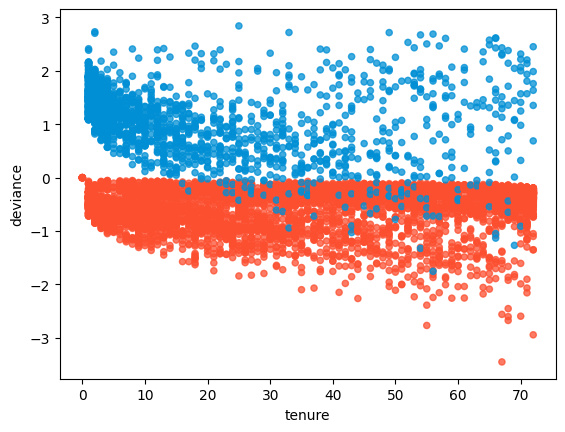

In [6]:
import numpy as np
r = cph.compute_residuals(train_df, 'deviance')
r.plot.scatter(
    x='tenure', y='deviance', c=np.where(r['churn'], '#008fd5', '#fc4f30'),
    alpha=0.75
)